# Descrição

**Trabalho BI - NLP WordClouds - Tratamento de Base de Reclamações**

Professor: Leonardo Alfredo Forero Mendoza

Alunos: 

- Alaor de Carvalho Neto
- André Luis Maravilha
- Daniel Fidelis Marques
- Leonardo Cardoso Vicente
- Maicon Melo Alves

A base do trabalho são todas as reclamações fundamentadas que foram audiência no ano de 2017.

1- Por favor crie uma wordcloud para item:
- empresa
- estado
- serviço

2- Na coluna 'problema' retire os dados null

Sendo assim ao todo são 3 wordclouds para serem entregues em um arquivo word.

Códigos de referência da aula 8 e 9.


# Importação de Bibliotecas e definições iniciais

In [1]:
# Instalando biblioteca python-Levenshtein
!pip install python-Levenshtein

# Imports
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
import os
import requests
import Levenshtein as lev
import gensim

from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from PIL import Image
from collections import Counter

# Downloads NLTK
nltk.download('stopwords')
nltk.download('punkt')

# Referências para os arquivos
URL_CSV_FILE = "https://github.com/danielfidelis/BIWORDCLOUD/raw/master/codigo/base%20reclama%C3%A7%C3%B5es.csv"
URL_TEMPLATE_IMG = "https://github.com/danielfidelis/BIWORDCLOUD/raw/master/codigo/dislike.png"
CLOUD_FILE = URL_TEMPLATE_IMG.split("/")[-1]

# Tamnaho máximo de palavras na cloud
MAX_WORDS_CLOUD = 300

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Minhas stopwords
MINHAS_STOP_WORDS = [
    'solicita',
    'deseja',
    'bom',
    'dia',
    'etc',
    'etc.',
    's',
    'a',
    's/a',
    'ltda',
    'matriz',
    'sa',
    's.a.',
    's.a',
    'nao',
]

# Funções gerais

## Função para downlad da imagem template


In [3]:
def download_cloud_img():
  if not os.path.isfile(CLOUD_FILE):
    # Realiza o download
    file = requests.get(URL_TEMPLATE_IMG, stream=True)
    dump = file.content
    with open(CLOUD_FILE,'wb') as f:
      f.write(dump)
    del dump


## Função para gerar wordcloud

In [4]:
def gerar_nuvem(obj):
  """
  Gera a nuvem baseada no tipo recebido
  texto ou dicionário de frequências
  """
  maskArray = np.array(Image.open(CLOUD_FILE))
  wordcloud = WordCloud(collocations=False, background_color = "#FFFFFF", max_words = MAX_WORDS_CLOUD, mask = maskArray, contour_width=3, max_font_size=200)
  if type(obj) == dict:
    wordcloud.generate_from_frequencies(obj)
  else: # Tipo = texto
    wordcloud.generate(obj)

  plt.figure(figsize=(12,10))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

# Importação e análise descritiva dos dados

In [5]:
# Importa os dados
download_cloud_img()
df = pd.read_csv(URL_CSV_FILE, encoding="windows-1252", sep=";")
#df = df.head(500) # Para testes

# Retira espaços das colunas
[df.rename(columns = {c: c.strip()}, inplace=True) for c in df.columns]

# Define colunas de análise
COL_ANALISE = ['estado', 'empresa', 'serviço', 'problema']

# Ajusta os tipos das colunas de análise
for col in COL_ANALISE:
  df[col].fillna("", inplace=True)
  df[col] = df[col].astype('str')

In [6]:
# Informações gerais
df[COL_ANALISE].describe()

,estado,empresa,serviço,problema
count,42307,42307,42307,42307
unique,17,11215,193,168
top,SP,TELEFONICA BRASIL S/A,"Telefone ( Convencional, Celular, Interfone, E...",
freq,8127,846,5149,8936


In [7]:
# Verificando os dados
df.head()

,Regiao,estado,empresa,subsidiaria,area,serviço,problema,faixa etarea
0,Sudeste,SP,ITAÚ UNIBANCO S/A,BANCO ITAÚ/BANCO UNIBANCO,"BANCOS MÚLTIPLOS, COM CARTEIRA COMERCIAL",Outros Contratos,"Contrato (não cumprimento, alteração, transfer...",entre 31 a 40 anos
1,Sudeste,SP,CLARO S/A,NET,NaN,Telefonia Fixa ( Plano de Expansão / Compra e ...,Contrato - Rescisão/alteração unilateral,mais de 70 anos
2,Sudeste,SP,ELETROPAULO METROPOLITANA ELETRICIDADE DE S PAULO,ELETROPAULO METROPOLITANA,DISTRIBUIÇÃO DE ENERGIA ELÉTRICA,Energia Elétrica,PID - Pedido de Indenização por Danos Morais,entre 31 a 40 anos
3,Sudeste,SP,GNN GARAGENS LTDA - EPP,NETPARK.COM.BR,ESTACIONAMENTO DE VEÍCULOS,"Estacionamento ( Particular, Supermercado, Sho...","Vicio de qualidade (mal executado, inadequado,...",entre 31 a 40 anos
4,Sudeste,SP,CLARO S/A,CLARO / NET / EMBRATEL / CLAROTV,TELEFONIA MÓVEL CELULAR,Telefonia Fixa ( Plano de Expansão / Compra e ...,"Vicio de qualidade (mal executado, inadequado,...",entre 41 a 50 anos


# Limpeza nos textos das colunas de análise

Realiza "limpeza" nos dados com remoção de stopwords, pontuação e mantendo valores alfanuméricos.

In [8]:
def clean(texto):
  """
  Limpa o texto retirando pontuação e stopwords.
  Retorna o texto "limpo"
  """
  tokens = nltk.word_tokenize(texto, language='portuguese')
  tokens = gensim.utils.simple_preprocess(str(tokens), deacc=True)
  tokens = [t for t in tokens if t not in nltk.corpus.stopwords.words('portuguese') + MINHAS_STOP_WORDS]
  tokens = [t for t in tokens if t.isalpha()]

  return " ".join(tokens)

colunas_limpar = ['empresa', 'serviço', 'problema']

for col in colunas_limpar:
  print("Processando: " + col)
  df[col] = df[col].apply(lambda x: clean(x))

Processando: empresa
Processando: serviço
Processando: problema


# Agrupando tokens de colunas por similaridade

Usa o método da distância de Levenshtein para juntar tokens similares.

Para cada coluna, verifica todos os tokens existentes e os ordena por frequencia. Em seguida. percorre a lista de tokens, associando-os caso esteja dentro dos critérios definidos para a função `processa_levenshtein`.

In [9]:
def processa_levenshtein(tokens, min_len=7, min_distance=1):
  """
  Compara cada palavra com a lista completa e associa uma palavra a outra caso
  esteja dentro da distância mínima
  """
  tokens = [t for t in tokens if len(t) > min_len] # Filtra os tokens pelo tamanho mínimo
  
  dic = {} # Dicionário para armazenar quando um token equivale a outro
  for t in tokens:
    for t_comp in dic:
      if lev.distance(t, t_comp) <= min_distance:
        dic[t] = t_comp
        break
    if t not in dic: dic[t] = t # Se não encontrou correspondência, guarda temporariamente o token no dicionário para sinalizar que foi processado

  dic = {x: dic[x] for x in dic if x != dic[x]} # Remove tokens que a chave é igual ao valor

  return dic

def clean_levenshtein(texto, dic_tokens):
  """
  Substitui o token pelo contido no dicionário caso exista.
  """
  tokens = texto.split(" ")
  tokens = [dic_tokens[t] if t in dic_tokens else t for t in tokens]

  return " ".join(tokens)

In [10]:
# Processa para cada coluna
colunas = ['empresa', 'serviço', 'problema']

for col in colunas:
  # Verifica os tokens existentes na coluna
  tokens = df[col].str.cat(sep=' ').split(' ') # Verifica os tokens
  tokens = [t for t in tokens if t.strip() != ""] # Retira espaços vazios
  dic_tokens = Counter(tokens) # Contabiliza as repetições
  tokens = [x[0] for x in sorted(dic_tokens.items(), reverse=True, key=lambda item:item[1])] # Ordena pelos mais frequentes
  dic_tokens = processa_levenshtein(tokens) # Verifica o dicionário de associações

  # Realiza as substituições nos textos das colunas
  df[col] = df[col].apply(lambda x: clean_levenshtein(x, dic_tokens))

  # Exibe informações
  print("Coluna " + col)
  print("Tokens = " + str(len(tokens)))
  print("Substituídos = " + str(len(dic_tokens)))
  print()

Coluna empresa
Tokens = 8328
Substituídos = 411

Coluna serviço
Tokens = 656
Substituídos = 12

Coluna problema
Tokens = 374
Substituídos = 15



In [11]:
# Verifica ínformações após o processo de limpeza para comparação com os
# dados "sem limpeza" feita anteriormente
df[['empresa', 'serviço', 'problema']].describe()

,empresa,serviço,problema
count,42307,42307,42307
unique,9282,192,164
top,telefonica brasil,telefone convencional celular interfone,
freq,1249,5149,8943


# Geração de wordclouds

## Estado / Empresa

O processamento está sendo feito levando em consideração a frequência de ocorrência na respectiva coluna do dataframe.

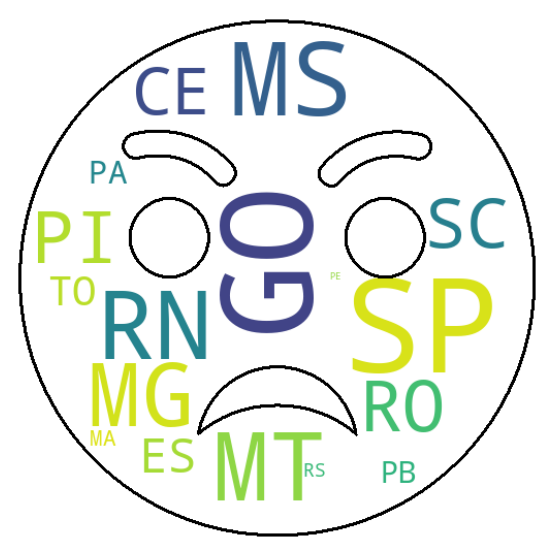

In [12]:
# Gera um dicionário com a frequencia de cada estado
df_group = df.loc[df['estado'].isnull()==False].groupby(['estado'])['estado'].count()
dic_estado = df_group.to_dict()

# Gera a nuvem
gerar_nuvem(dic_estado)

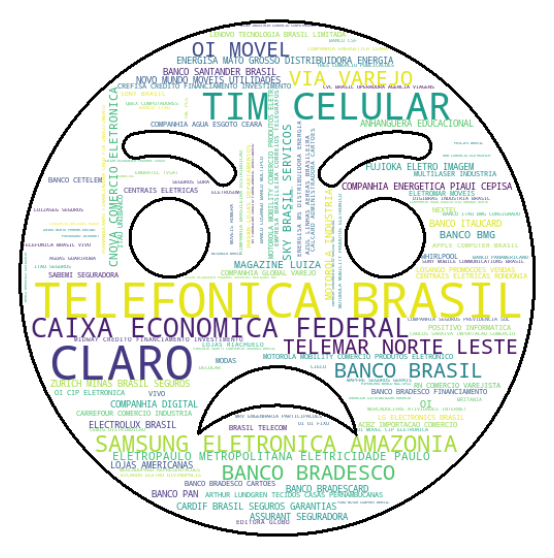

In [13]:
# Gera um dicionário com a frequencia
df['empresa'] = df['empresa'].str.upper()
df_group = df.loc[df['empresa'].isnull()==False].groupby(['empresa'])['empresa'].count()
dic_empresa = df_group.to_dict()

# Gera a nuvem
gerar_nuvem(dic_empresa)

## Problema / Serviço

Aqui verificamos que o tamanho médio da string das colunas problema e serviço é maior que o da outras colunas.

Decidimos então gerar as wordclouds de serviço e problema usando como palava cada token existente em cada coluna, representados por sua frequencia

In [14]:
# Lista os tamanhos de cada linha do dataframe
len_problema = list(df['problema'].str.len())
len_servico = list(df['serviço'].str.len())

# Coloca os tamanhos num dataframe para análise
list_len = []
for p, se in zip(len_problema, len_servico):
  list_len.append([p, se])

df_len = pd.DataFrame(data=list_len, columns=['problema', 'serviço'])
print("Tamnaho das strings das colunas")
df_len.describe()

Tamnaho das strings das colunas


,problema,serviço
count,42307.000000,42307.000000
mean,23.783558,28.747749
std,19.849266,18.585482
min,0.000000,4.000000
25%,13.000000,15.000000
50%,22.000000,20.000000
75%,30.000000,39.000000
max,113.000000,144.000000


In [15]:
# Retira valores nulos
serie_servico = df['serviço'].dropna()
serie_problema = df['problema'].dropna()

# Verifica os tokens de cada coluna
data_servico = serie_servico.str.cat(sep=' ')
data_problema = serie_problema.str.cat(sep=' ')

# Informa a quantidade de tokens individuais
print("Tokens únicos em serviço: {0}".format(len(set(data_servico.split(" ")))))
print("Tokens únicos em problema: {0}".format(len(set(data_problema.split(" ")))))

Tokens únicos em serviço: 644
Tokens únicos em problema: 361


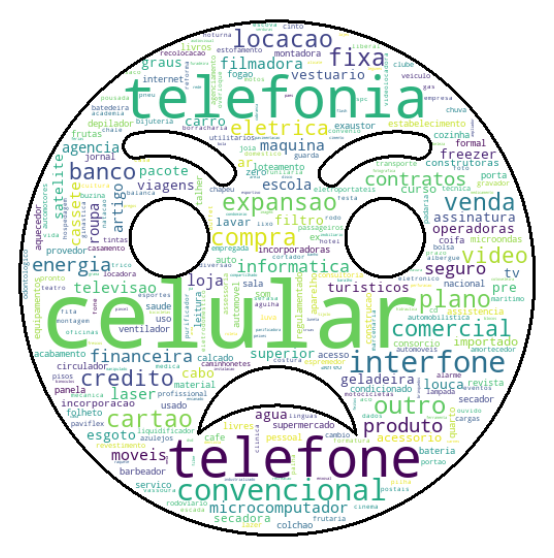

In [16]:
# Wordcloud de serviços
gerar_nuvem(data_servico)

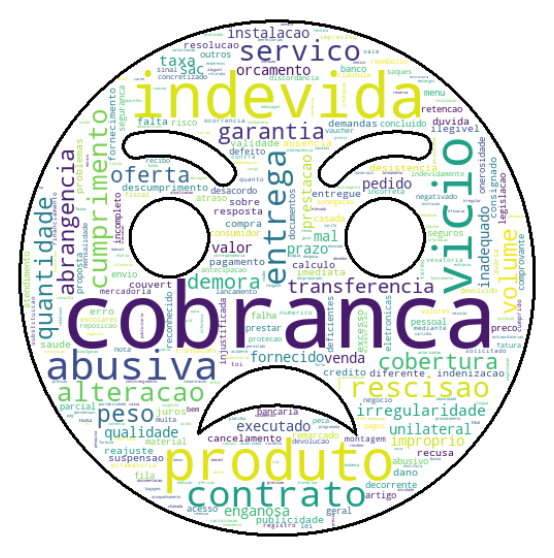

In [17]:
# Wordcloud de problemas
gerar_nuvem(data_problema)